In [ ]:
from pathlib import Path
import warnings
from subprocess import run
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pickle
import matplotlib.pyplot as plt
import prettypyplot as pplt
from itertools import product
from chespex.optimization.gaussian_process import GaussianProcess
from gpytorch.constraints import Interval
from gpytorch.distributions import MultivariateNormal
from scipy.stats import norm
from scipy.spatial.distance import cdist

pplt.use_style(true_black=True, sf=False)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.rcParams.update({"font.size": 9, "figure.dpi": 220, 'font.family': 'sans-serif', 'font.sans-serif': ['Arial']})
figpath = Path()
linewidth = 3.40457 # Two column page in inch
linewidth_double = 7.05826  # One column page in inch

## Setup

In [2]:
bead_types1 = list(product([0, 1], [0, 1, 2]))
bead_types2 = list(product([0.0, 0.33, 0.67, 1.0], [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]))
molecule_data1 = [torch.Tensor(c).flatten() for c in product(bead_types1, repeat=2)]
molecule_data2 = [torch.Tensor(c).flatten() for c in product(bead_types2, repeat=2)]
print(f'Number of molecule types: {len(molecule_data1)} and {len(molecule_data2)}')

Number of molecule types: 36 and 1296


In [ ]:
def molecule_function(x: tuple[float, float, float, float]) -> float:
    return -0.5 * (x[0] - x[2]) ** 2 + 0.5 * (x[0] - 0.3) ** 2 - x[1] - (x[3] - 1) ** 2

## Encoding

In [9]:
encoder1 = nn.Sequential(nn.Linear(4, 16), nn.ReLU(), nn.Linear(16, 16), nn.ReLU(), nn.Linear(16, 1))
decoder1 = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 4))
encoder2 = nn.Sequential(nn.Linear(4, 64), nn.ReLU(), nn.Linear(64, 32), nn.ReLU(), nn.Linear(32, 1))
decoder2 = nn.Sequential(nn.Linear(1, 64), nn.ReLU(), nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, 4))
optimizer1 = torch.optim.Adam(list(encoder1.parameters()) + list(decoder1.parameters()), lr=0.001)
optimizer2 = torch.optim.Adam(list(encoder2.parameters()) + list(decoder2.parameters()), lr=0.001)
loss_fn = nn.MSELoss()

In [10]:
loss_history1 = []
batch1 = torch.stack(molecule_data1)
for epoch in range(30000):
    optimizer1.zero_grad()
    latent = encoder1(batch1)
    reconstruction = decoder1(latent)
    loss = loss_fn(reconstruction, batch1) + 0.05 * torch.linalg.vector_norm(latent, dim=1).mean()
    loss.backward()
    loss_history1.append(loss.item())
    optimizer1.step()
    print(f"Epoch {epoch}, loss {loss.item():.4f}", end="\r")

In [11]:
loss_history2 = []
batch2 = torch.stack(molecule_data2)
for epoch in range(30000):
    optimizer2.zero_grad()
    latent = encoder2(batch2)
    reconstruction = decoder2(latent)
    loss = loss_fn(reconstruction, batch2) + 0.05 * torch.linalg.vector_norm(latent, dim=1).mean()
    loss.backward()
    loss_history2.append(loss.item())
    optimizer2.step()
    print(f"Epoch {epoch}, loss {loss.item():.4f}", end="\r")

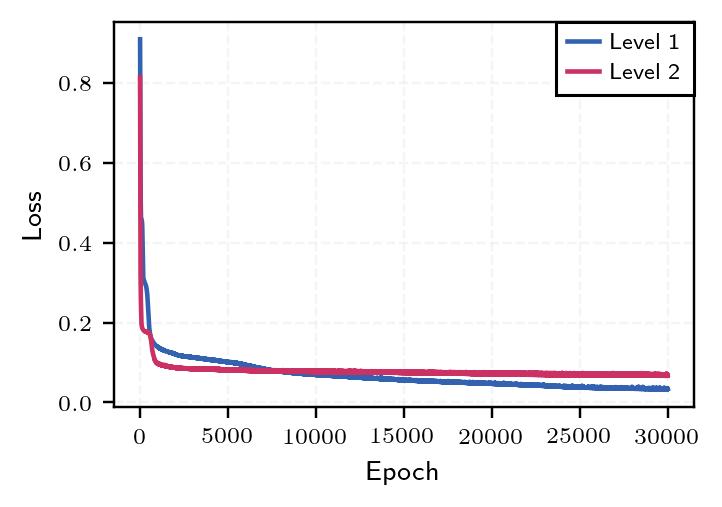

In [12]:
plt.figure(figsize=(linewidth, 2.5))
plt.plot(loss_history1, label="Level 1")
plt.plot(loss_history2, label="Level 2")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [13]:
for molecule in batch1[torch.randperm(len(batch1))[:5]]:
    latent = encoder1(molecule)
    reconstruction = decoder1(latent)
    print(f"Level 1 - Input: {[f'{e:4.2f}' for e in molecule]} Output: {[f'{e:5.2f}' for e in reconstruction]} Latent: {latent.item():5.2f}")
for molecule in batch2[torch.randperm(len(batch1))[:5]]:
    latent = encoder2(molecule)
    reconstruction = decoder2(latent)
    print(f"Level 2 - Input: {[f'{e:4.2f}' for e in molecule]} Output: {[f'{e:5.2f}' for e in reconstruction]} Latent: {latent.item():5.2f}")

Level 1 - Input: ['0.00', '0.00', '0.00', '1.00'] Output: [' 0.14', ' 0.18', '-0.06', ' 1.06'] Latent: -0.02
Level 1 - Input: ['1.00', '1.00', '1.00', '2.00'] Output: [' 0.37', ' 1.02', ' 0.36', ' 2.00'] Latent:  0.08
Level 1 - Input: ['1.00', '2.00', '1.00', '0.00'] Output: [' 1.03', ' 2.21', ' 0.99', '-0.03'] Latent: -0.13
Level 1 - Input: ['0.00', '1.00', '1.00', '1.00'] Output: [' 0.10', ' 0.98', ' 0.97', ' 0.99'] Latent: -0.05
Level 1 - Input: ['0.00', '0.00', '0.00', '2.00'] Output: [' 0.67', ' 0.29', ' 0.07', ' 1.99'] Latent:  0.06
Level 2 - Input: ['0.00', '0.00', '0.67', '0.25'] Output: [' 0.17', ' 0.36', ' 0.61', ' 0.17'] Latent: -0.11
Level 2 - Input: ['0.00', '0.00', '1.00', '2.00'] Output: [' 0.53', ' 0.15', ' 0.52', ' 1.79'] Latent: -0.03
Level 2 - Input: ['0.00', '0.00', '1.00', '0.00'] Output: [' 0.32', ' 0.36', ' 0.88', ' 0.16'] Latent: -0.10
Level 2 - Input: ['0.00', '0.00', '0.67', '1.75'] Output: [' 0.26', ' 0.20', ' 0.26', ' 1.86'] Latent: -0.02
Level 2 - Input: ['

## Visualization

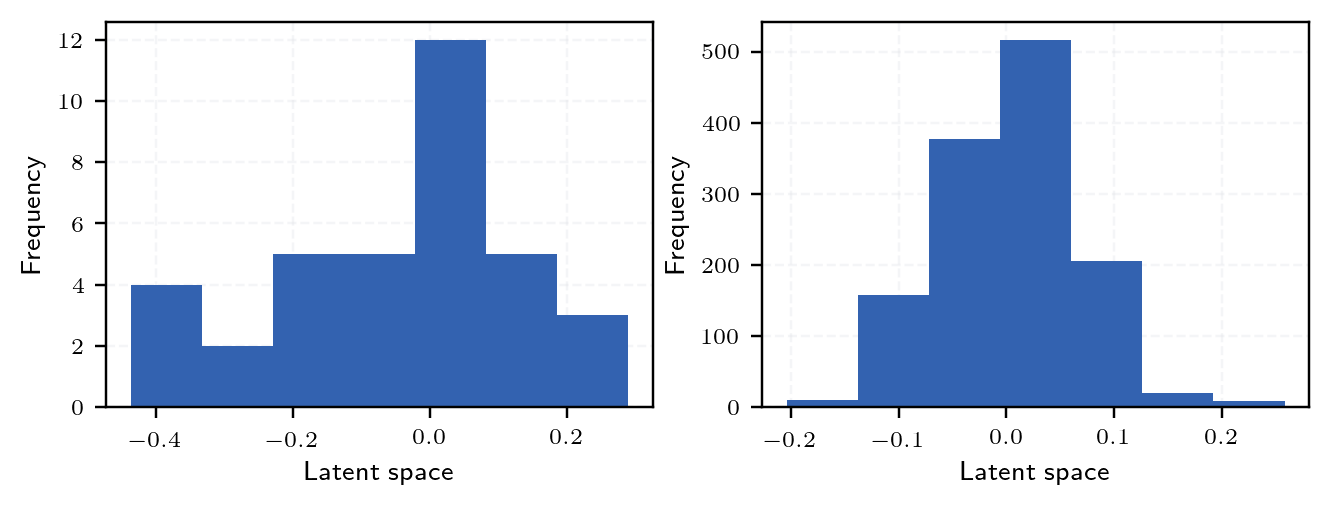

In [14]:
latent_space1 = encoder1(batch1).detach().numpy()
latent_space2 = encoder2(batch2).detach().numpy()
fig, axs = plt.subplots(ncols=2, figsize=(linewidth_double, 2.5))
axs[0].hist(latent_space1, bins=7)
axs[0].set(xlabel="Latent space", ylabel="Frequency")
axs[0].grid(alpha=0.3)
axs[1].hist(latent_space2, bins=7)
axs[1].set(xlabel="Latent space", ylabel="Frequency")
axs[1].grid(alpha=0.3)
plt.show()

In [15]:
mapping = []
for molecule in molecule_data2:
    mapping.append(np.argmin(torch.linalg.norm(molecule - batch1, dim=1).numpy()))
mapping = np.array(mapping)

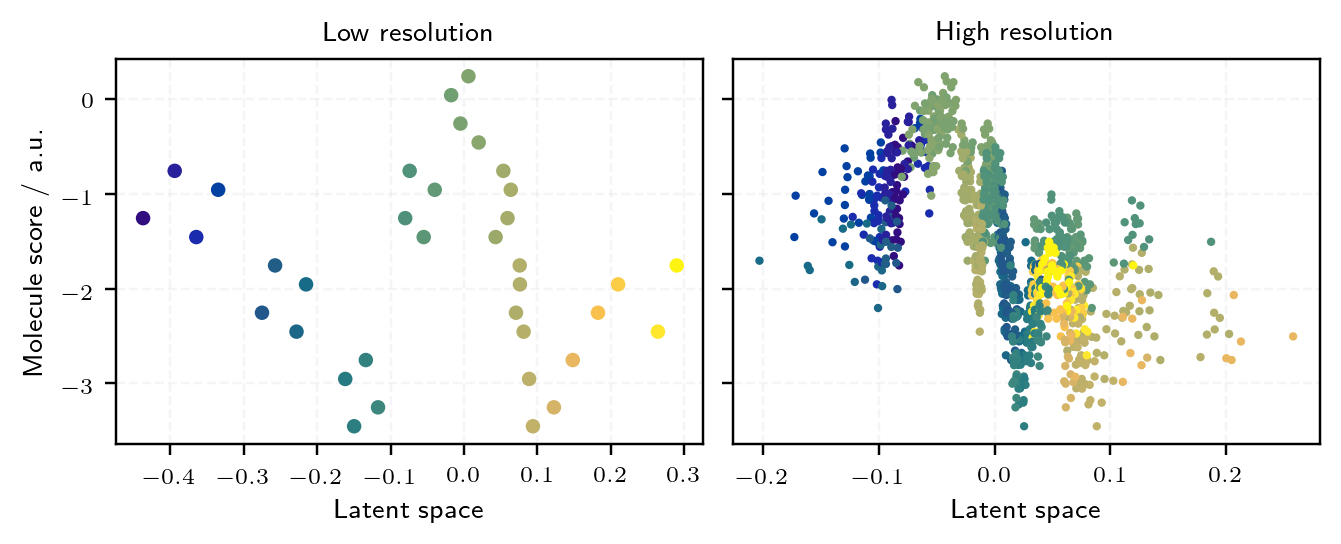

In [168]:
molecule_values1 = np.array([molecule_function(molecule.numpy()) for molecule in molecule_data1])
molecule_values2 = np.array([molecule_function(molecule.numpy()) for molecule in molecule_data2])
fig, axs = plt.subplots(ncols=2, figsize=(linewidth_double, 2.5), sharey=True)
axs[0].scatter(latent_space1, molecule_values1, s=14, c=latent_space1)
axs[0].set(xlabel="Latent space", ylabel="Molecule score / a.u.")
axs[0].set_title('Low resolution', fontsize=9)
axs[0].grid(alpha=0.3)
axs[1].scatter(latent_space2, molecule_values2, s=3, c=latent_space1[mapping])
axs[1].set(xlabel="Latent space")
axs[1].set_title('High resolution', fontsize=9)
axs[1].grid(alpha=0.3)
fig.subplots_adjust(wspace=0.05)
plt.savefig(figpath / "toy-example-latent-space.pdf")
plt.show()

In [17]:
for i in np.argsort(molecule_values2)[-3:]:
    print(f'Molecule function at x = {[f"{e:.2f}" for e in molecule_data2[i].tolist()]}: {molecule_values2[i]:.3f}')

Molecule function at x = ['1.00', '0.00', '1.00', '1.25']: 0.182
Molecule function at x = ['1.00', '0.00', '0.67', '1.00']: 0.191
Molecule function at x = ['1.00', '0.00', '1.00', '1.00']: 0.245


In [19]:
with open('molecule_data.pkl', 'wb') as f:
    pickle.dump((batch1, latent_space1, molecule_values1, batch2, latent_space2, molecule_values2), f)

In [20]:
with open('molecule_data.pkl', 'rb') as f:
    batch1, latent_space1, molecule_values1, batch2, latent_space2, molecule_values2 = pickle.load(f)

## Optimization

In [22]:
def expected_improvement(prediction_mean: torch.Tensor, prediction_stddev: torch.Tensor, current_best: float, xi: float = 1.01) -> np.ndarray:
    # Expected improvement acquisition function
    z = (prediction_mean.numpy() - current_best * xi) / prediction_stddev.numpy()
    return (prediction_mean.numpy() - current_best * xi) * norm.cdf(z) + prediction_stddev.numpy() * norm.pdf(z)

#### Multi-level optimization

In [106]:
def two_level_next_point(dataset: pd.DataFrame):
    level = dataset['level'].iloc[-1]
    if level == 1 and (np.abs(dataset['prediction'].iloc[-3:] - dataset['result'].iloc[-3:]) < 0.85).all() and len(dataset[dataset['level'] == 1]) > 7:
        level = 2
    gp1 = GaussianProcess(lengthscale_constraint=Interval(1e-4, 10), noise_constraint=Interval(5e-4, 2e-3))
    level1_dataset = dataset[dataset['level'] == 1]
    gp1.fit(np.array(level1_dataset["latent"].tolist()), level1_dataset["result"])
    prediction1 = gp1.predict(latent_space1)
    if level == 1:
        expected_improvement1 = expected_improvement(prediction1.mean, prediction1.stddev, level1_dataset['result'].max())
        next_point_ndx1 = np.ma.masked_array(expected_improvement1, mask=np.isin(np.arange(len(latent_space1)), level1_dataset['index'])).argmax()
        return level, next_point_ndx1, prediction1.mean[next_point_ndx1].item(), prediction1.stddev[next_point_ndx1].item()
    else:
        gp2 = GaussianProcess(lengthscale_constraint=Interval(1e-4, 10), noise_constraint=Interval(5e-4, 2e-3))
        level2_dataset = dataset[dataset['level'] == 2]
        if len(level2_dataset) > 0:
            delta = level2_dataset["result"] - prediction1.mean[mapping].numpy()[level2_dataset['index']]
            gp2.fit(np.array(level2_dataset["latent"].tolist()), delta)
        prediction2 = gp2.predict(latent_space2)
        prediction2_mean = prediction2.mean.detach() + prediction1.mean[mapping]
        expected_improvement2 = expected_improvement(prediction2_mean, prediction2.stddev, level2_dataset['result'].max())
        promising_parents = level1_dataset['index'][np.nonzero(level1_dataset['result'].values > np.sort(level1_dataset['result'].values)[-5])[0]]
        promising_children = np.isin(mapping, promising_parents)
        promising_children = cdist(latent_space2, latent_space2[promising_children], metric='euclidean').min(axis=1) < 0.05
        mask = ~promising_children | np.isin(np.arange(len(latent_space2)), level2_dataset["index"])
        next_point_ndx2 = np.ma.masked_array(expected_improvement2, mask=mask).argmax()
        return level, next_point_ndx2, prediction2_mean[next_point_ndx2].item(), prediction2.stddev[next_point_ndx2].item()

In [64]:
dataset = pd.DataFrame([
    {"level": 1, "index": i, "latent": latent_space1[i], "result": molecule_values1[i], "prediction": np.nan, "stddev": np.nan}
    for i in np.random.choice(len(latent_space1), size=3, replace=False)
])
filepaths = []
for i in range(52):
    level, next_point_ndx, prediction_mean, prediction_stddev = two_level_next_point(dataset)
    next_point = {"level": level, "index": next_point_ndx, "prediction": prediction_mean, "stddev": prediction_stddev}
    if level == 1:
        next_point.update({"latent": latent_space1[next_point_ndx], "result": molecule_values1[next_point_ndx]})
    else:
        next_point.update({"latent": latent_space2[next_point_ndx], "result": molecule_values2[next_point_ndx]})
    dataset = pd.concat([dataset, pd.DataFrame([next_point])], ignore_index=True)
    print(f"{i:>2} Adding point {next_point['result']:.3f} on level {level}, error: {abs(next_point['result'] - next_point['prediction']):.3f}")
    fig, axs = plt.subplots(ncols=2, figsize=(linewidth_double, 2.5), sharey=True)
    axs[0].scatter(latent_space1, molecule_values1, s=6)
    dataset_1 = dataset[dataset['level'] == 1]
    dataset_2 = dataset[dataset['level'] == 2]
    axs[0].scatter(dataset_1["latent"], dataset_1["result"], s=10)
    axs[0].set_title(f'{len(dataset_1)} + {len(dataset_2)} = {len(dataset_1) + len(dataset_2)} points')
    axs[1].scatter(latent_space2, molecule_values2, s=3, label="All points", color="tab:blue")
    axs[1].scatter(dataset_2["latent"], dataset_2["result"], s=6, label="Tested points", color="tab:orange")
    axs[1].axvline(latent_space2[molecule_values2.argmax()], color="yellow", linestyle="--", alpha=0.5)
    axs[1].legend()
    if level == 1:
        axs[0].axvline(latent_space1[next_point_ndx], color="black", linestyle="--", alpha=0.5)
    else:
        axs[1].axvline(latent_space2[next_point_ndx], color="black", linestyle="--", alpha=0.5)
    filepaths.append("multi_level_{:02d}.png".format(len(dataset_1) + len(dataset_2) - 4))
    plt.savefig(filepaths[-1], transparent=False)
    plt.close()
    # Check if optimization is finished
    if level == 2 and next_point_ndx == molecule_values2.argmax():
        break
run(f"convert -loop 0 -delay 10 {' '.join(filepaths[:-1])} -delay 200 {filepaths[-1]} multi_level.gif; rm multi_level_*.png", shell=True)

 0 Adding point -1.455 on level 1, error: 0.018
 1 Adding point -1.255 on level 1, error: 0.061
 2 Adding point -1.955 on level 1, error: 0.140
 3 Adding point -3.255 on level 1, error: 1.203
 4 Adding point -1.755 on level 1, error: 0.457
 5 Adding point -2.255 on level 1, error: 0.200
 6 Adding point -0.255 on level 1, error: 2.053
 7 Adding point -0.455 on level 1, error: 0.140
 8 Adding point -0.955 on level 1, error: 0.085
 9 Adding point 0.245 on level 1, error: 0.513
10 Adding point -0.955 on level 2, error: 0.814
11 Adding point 0.006 on level 2, error: 1.045
12 Adding point -0.432 on level 2, error: 0.922
13 Adding point -0.372 on level 2, error: 0.648
14 Adding point -0.059 on level 2, error: 0.139
15 Adding point -0.182 on level 2, error: 0.224
16 Adding point -0.432 on level 2, error: 0.558
17 Adding point -0.122 on level 2, error: 0.248
18 Adding point -1.486 on level 2, error: 0.579
19 Adding point -1.617 on level 2, error: 0.340
20 Adding point -0.048 on level 2, error: 

CompletedProcess(args='convert -loop 0 -delay 10 multi_level_00.png multi_level_01.png multi_level_02.png multi_level_03.png multi_level_04.png multi_level_05.png multi_level_06.png multi_level_07.png multi_level_08.png multi_level_09.png multi_level_10.png multi_level_11.png multi_level_12.png multi_level_13.png multi_level_14.png multi_level_15.png multi_level_16.png multi_level_17.png multi_level_18.png multi_level_19.png multi_level_20.png multi_level_21.png multi_level_22.png multi_level_23.png multi_level_24.png multi_level_25.png multi_level_26.png multi_level_27.png multi_level_28.png multi_level_29.png multi_level_30.png multi_level_31.png multi_level_32.png multi_level_33.png multi_level_34.png multi_level_35.png multi_level_36.png multi_level_37.png -delay 200 multi_level_38.png multi_level.gif; rm multi_level_*.png', returncode=0)

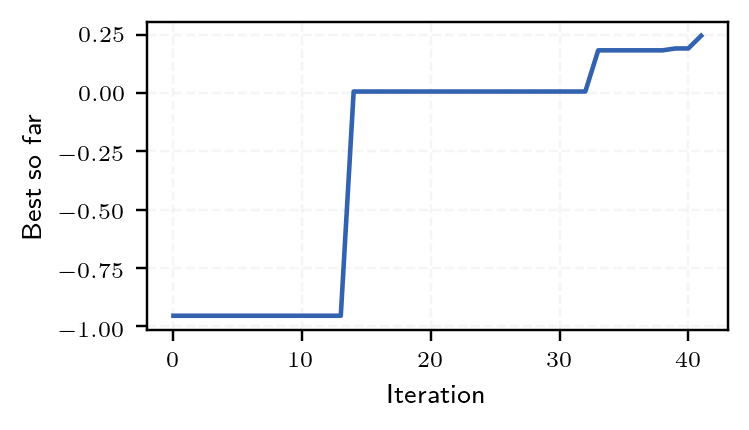

In [65]:
plt.figure(figsize=(linewidth, 2))
dataset_1 = dataset[dataset['level'] == 1]
dataset_2 = dataset[dataset['level'] == 2]
best_so_far = [dataset_2['result'].iloc[0]] * len(dataset_1) + [max(dataset_2['result'].iloc[: i + 1]) for i in range(len(dataset_2))]
plt.plot(best_so_far)
plt.xlabel("Iteration")
plt.ylabel("Best so far")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
multi_level_results = []
while len(multi_level_results) < 50:
    try:
        dataset = pd.DataFrame([
            {"level": 1, "index": i, "latent": latent_space1[i], "result": molecule_values1[i], "prediction": np.nan, "stddev": np.nan}
            for i in np.random.choice(len(latent_space1), size=3, replace=False)
        ])
        for j in range(52):
            level, next_point_ndx, prediction_mean, prediction_stddev = two_level_next_point(dataset)
            next_point = {"level": level, "index": next_point_ndx, "prediction": prediction_mean, "stddev": prediction_stddev}
            if level == 1:
                next_point.update({"latent": latent_space1[next_point_ndx], "result": molecule_values1[next_point_ndx]})
            else:
                next_point.update({"latent": latent_space2[next_point_ndx], "result": molecule_values2[next_point_ndx]})
            dataset = pd.concat([dataset, pd.DataFrame([next_point])], ignore_index=True)
            current_best = dataset[dataset['level'] == 2]['result'].max()
            print(f"Run {i}, step {j} (cur: {next_point['result']:.3f}, best: {current_best:.3f}, level {level}, l1-steps: {len(dataset[dataset['level'] == 1])})", end="\r")
        multi_level_results.append(dataset[["level", "latent", "result"]].values)
        with open('multi_level_results.pkl', 'wb') as f:
            pickle.dump(multi_level_results, f)
    except Exception as e:
        print(f"Run {i} failed: {e}")

#### Reference optimization

In [66]:
def suggest_next_point(dataset: pd.DataFrame):
    gp = GaussianProcess(
        lengthscale_constraint=Interval(1e-4, 10),
        noise_constraint=Interval(1e-4, 10),
    )
    with warnings.catch_warnings(action="ignore"):
        gp.fit(np.array(dataset["latent"].tolist()), dataset['result'])
        prediction = gp.predict(latent_space2)
        expected_improvements = expected_improvement(prediction.mean, prediction.stddev, current_best=max(dataset['result']))
    next_index = np.ma.masked_array(expected_improvements, mask=np.isin(np.arange(len(latent_space2)), dataset['index'])).argmax()
    return next_index, prediction.mean[next_index].item(), prediction.stddev[next_index].item()

In [68]:
dataset = pd.DataFrame([
    {"index": i, "latent": latent_space2[i], "result": molecule_values2[i], "prediction": np.nan, "stddev": np.nan}
    for i in np.random.choice(len(latent_space2), size=3, replace=False)
])
filepaths = []
for i in range(52):
    next_ndx, prediction_mean, prediction_stddev = suggest_next_point(dataset)
    next_point = {"index": next_ndx, "prediction": prediction_mean, "stddev": prediction_stddev, "latent": latent_space2[next_ndx], "result": molecule_values2[next_ndx]}
    dataset = pd.concat([dataset, pd.DataFrame([next_point])], ignore_index=True)
    print(f"{i:>2} Adding point {molecule_values2[next_ndx]:.3f}")
    # Plot and print result
    plt.figure(figsize=(linewidth, 2.5))
    plt.scatter(latent_space2, molecule_values2, s=3)
    plt.scatter(dataset["latent"], dataset['result'], s=10)
    plt.axvline(latent_space2[next_ndx], color="black", linestyle="--", alpha=0.5)
    plt.axvline(latent_space2[molecule_values2.argmax()], color="yellow", linestyle="--", alpha=0.5)
    plt.grid(alpha=0.3)
    plt.title(f"Dataset size: {len(dataset)}")
    filepaths.append("simple_{:02d}.png".format(len(dataset) - 4))
    plt.savefig(filepaths[-1], transparent=False)
    plt.close()
    # Break if finished
    if next_ndx == molecule_values2.argmax():
        break
run(f"convert -loop 0 -delay 10 {' '.join(filepaths[:-1])} -delay 200 {filepaths[-1]} simple.gif; rm simple_*.png", shell=True)

 0 Adding point -1.000
 1 Adding point -2.250
 2 Adding point -0.679
 3 Adding point -0.455
 4 Adding point -0.179
 5 Adding point -1.804
 6 Adding point -0.322
 7 Adding point -0.054
 8 Adding point -2.505
 9 Adding point -0.242
10 Adding point -0.517
11 Adding point -0.017
12 Adding point -0.705
13 Adding point -0.009
14 Adding point -0.767
15 Adding point -0.205
16 Adding point -2.049
17 Adding point -1.017
18 Adding point -0.705
19 Adding point -0.259
20 Adding point -0.429
21 Adding point 0.000
22 Adding point -0.307
23 Adding point -0.057
24 Adding point 0.068
25 Adding point -0.469
26 Adding point -0.005
27 Adding point -0.229
28 Adding point -0.219
29 Adding point 0.245


CompletedProcess(args='convert -loop 0 -delay 10 simple_00.png simple_01.png simple_02.png simple_03.png simple_04.png simple_05.png simple_06.png simple_07.png simple_08.png simple_09.png simple_10.png simple_11.png simple_12.png simple_13.png simple_14.png simple_15.png simple_16.png simple_17.png simple_18.png simple_19.png simple_20.png simple_21.png simple_22.png simple_23.png simple_24.png simple_25.png simple_26.png simple_27.png simple_28.png -delay 200 simple_29.png simple.gif; rm simple_*.png', returncode=0)

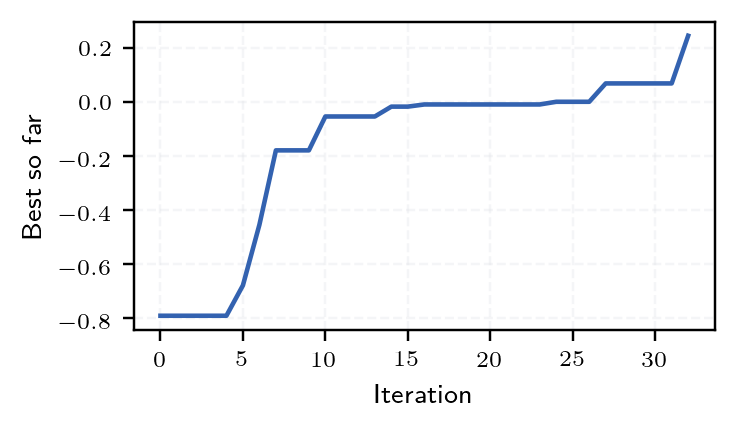

In [69]:
plt.figure(figsize=(linewidth, 2))
best_so_far = [max(dataset["result"][: i + 1]) for i in range(len(dataset["result"]))]
plt.plot(best_so_far)
plt.xlabel("Iteration")
plt.ylabel("Best so far")
plt.grid(alpha=0.3)
plt.show()

In [77]:
simple_results = []
for i in range(50):
    dataset = pd.DataFrame([
        {"level": 1, "index": i, "latent": latent_space1[i], "result": molecule_values1[i], "prediction": np.nan, "stddev": np.nan}
        for i in np.random.choice(len(latent_space1), size=3, replace=False)
    ])
    for j in range(52):
        next_ndx, prediction_mean, prediction_stddev = suggest_next_point(dataset)
        next_point = {"index": next_ndx, "prediction": prediction_mean, "stddev": prediction_stddev, "latent": latent_space2[next_ndx], "result": molecule_values2[next_ndx]}
        dataset = pd.concat([dataset, pd.DataFrame([next_point])], ignore_index=True)
        print(f"Run {i}, step {j} ({next_point['result']:6>.3f})", end="\r")
    simple_results.append(dataset[["latent", "result"]].values)
    with open('simple_results.pkl', 'wb') as f:
        pickle.dump(simple_results, f)

#### Comparison

In [125]:
with open('multi_level_results.pkl', 'rb') as f:
    multi_level_results = pickle.load(f)
with open('simple_results.pkl', 'rb') as f:
    simple_results = pickle.load(f)
print(f"Multi-level results: {len(multi_level_results)}, Simple results: {len(simple_results)}")

Multi-level results: 50, Simple results: 50


In [126]:
def best_so_far(dataset: np.ndarray) -> np.ndarray:
    if dataset.shape[1] == 3:
        result = np.zeros(len(dataset))
        for i in range(len(dataset) - 1, -1, -1):
            result[i] = result[i + 1] if dataset[i, 0] == 1 else dataset[i, 2]
    else:
        result = dataset[:,1]
    return np.maximum.accumulate(result)     

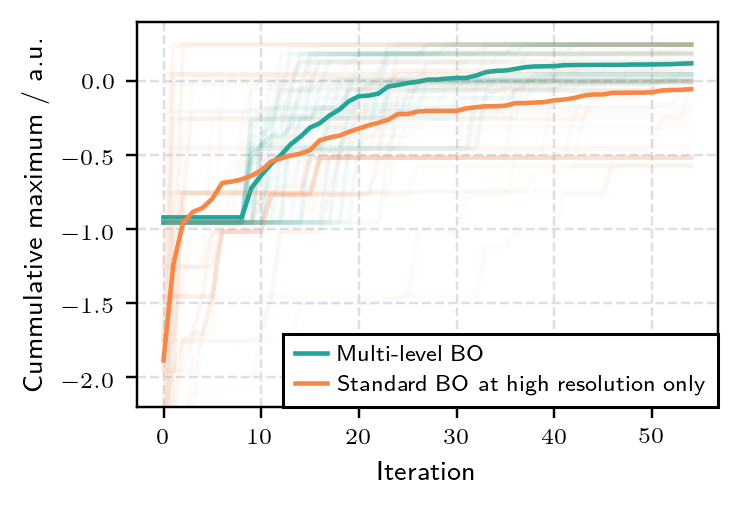

In [167]:
fig, axs = plt.subplots(figsize=(linewidth, 2.5))
ml_mean = np.zeros(len(multi_level_results[0]), dtype=float)
sl_mean = np.zeros(len(simple_results[0]), dtype=float)
for mlres in multi_level_results:
    cum_best = best_so_far(mlres)
    ml_mean += cum_best
    axs.plot(cum_best, color=colors[2], alpha=0.03)
axs.plot(ml_mean / len(multi_level_results), color=colors[2], label="Multi-level BO")
for sres in simple_results:
    cum_best = best_so_far(sres)
    sl_mean = sl_mean + cum_best
    axs.plot(cum_best, color=colors[3], alpha=0.03)
axs.plot(sl_mean / len(simple_results), color=colors[3], label="Standard BO at high resolution only")
axs.set(ylim=(- 2.2, 0.4), xlabel="Iteration", ylabel="Cummulative maximum / a.u.")
plt.legend()
plt.savefig(figpath / "toy-example-cummax-comparison.pdf")
plt.show()

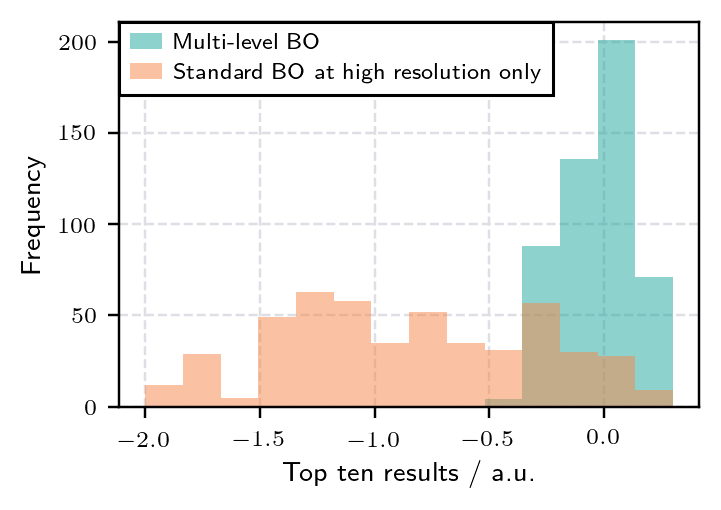

In [166]:
fig, axs = plt.subplots(figsize=(linewidth, 2.5))
ml_top_ten = []
sl_top_ten = []
for mlres in multi_level_results:
    ml_top_ten.extend(np.sort(mlres[np.nonzero(mlres[:,0] == 2)[0], 2])[-10:])
for sres in simple_results:
    sl_top_ten.extend(np.sort(sres[-10:, 1]))
bins = np.linspace(-2, 0.3, 15)
hist, edges = np.histogram(ml_top_ten, bins=bins)
axs.bar((edges[:-1] + edges[1:]) / 2, hist, width=np.diff(edges), alpha=0.5, color=colors[2], label="Multi-level BO")
# axs.hist(ml_top_ten, bins=bins, alpha=0.5, color=colors[2], label="Multi-level")
hist, edges = np.histogram(sl_top_ten, bins=bins)
axs.bar((edges[:-1] + edges[1:]) / 2, hist, width=np.diff(edges), alpha=0.5, color=colors[3], label="Standard BO at high resolution only")
#axs.hist(sl_top_ten, bins=bins, alpha=0.5, color=colors[3], label="Single-level")
axs.set(xlabel="Top ten results / a.u.", ylabel="Frequency")
plt.legend()
plt.savefig(figpath / "toy-example-histogram-comparison.pdf")
plt.show()